# XIC Peak Quality Evaluation Model Training (RandomForestClassifier)

Code for training a RandomForestClassifier for XIC peak quality evaluation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import joblib
import pandas as pd
import time
import scipy.stats as stats
from collections import Counter
import tarfile

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog

from IPython.display import display, clear_output
sys.path.append('./tools/')
from tools import tools

rTools=tools()


In [2]:
#File path definitions
modelEvalPath="./modelsAssessment/XIC-peakQlty/"
MLModelsPath="./models/XIC-peakQlty/"
trainingDataFile="./dataSets/XIC-peakQlty/XIC-PeakQlty_trainingData_vd.tar.gz"


# **Data preprocessing**

In [3]:
# Loading of training data
with tarfile.open(trainingDataFile, "r:gz") as tar:
    data = joblib.load(tar.extractfile(os.path.basename(trainingDataFile).replace(".tar.gz",".pkl")))
print(data["description"])
tar.close()



    This dataset contains extracted ion current (XIC) images representing noisy, chromatographically problematic 
    (e.g., multi-peak or unstable), and acceptable signal profiles (including high-quality, split, or overlapping peaks).
  
    ================================   ==============
    Number of instances: 	 	6512
    Images: 	 6512 (75x75 pixels)
    	XIC image representations
    Target (Ionized species): 		integer
        Noise: 0 (1192)
        Problematic signal: 1 (677)
        Acceptable signal: 2 (3368)
    ================================   ==============

    Keys
    -------
        images : list (6512, (75x75))
        target: list (6512)
        target_names: dict (target labels names)
        description: str
            Full dataset description

    Use:
    ----
    
    >>> import joblib
    >>> dataSet=joblib.load("XIC-PeakQlty_trainingData_vd.pkl")
    >>> print(dataSet['description'])
    >>> dataSet['target']
    >>> dataSet['target_names']


    


In [4]:
#Transforms XIC peak images into Histogram of Oriented Gradients (HOG) representations 
# to extract spatial–intensity features for model training.
orientations=6
cells_per_block=4
pixels_per_cell=12

training_data={'target':np.array(data['target'].copy())}
training_data['features']=np.array([ hog(img,pixels_per_cell=(pixels_per_cell,pixels_per_cell),
        cells_per_block=(cells_per_block, cells_per_block), 
        orientations=orientations,block_norm='L2-Hys',
        feature_vector=True
    )  for img in data['images']])

## Splitting the training dataset

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    training_data['features'], 
    training_data['target'], 
    test_size=0.2, 
    random_state=42,
    stratify=training_data['target']
)


# **RandomForestClassifier Hyperparameter Optimization and Model Fitting**

In [6]:
# Random Forest Classifier hyperparameter optimization by grid search

isHyperparameterOpt=False
  
if isHyperparameterOpt:
    XICPeakQltyClassifier=RandomForestClassifier()  


    grid_parameters=[{"n_estimators":[50,100,150,200,250],
                      "max_features":[1.0,0.75,0.5,0.25,0.1],
                      'criterion': ['log_loss', 'entropy', 'gini'],
                      'max_depth': [None],
                      'ccp_alpha': [0.00,0.005,0.01, 0.05,0.1],
                      'random_state':[42]
                      }]

    startTime = time.monotonic()
    grid_search=GridSearchCV(XICPeakQltyClassifier, 
                             grid_parameters,
                             cv=5,
                             scoring=None,
                             n_jobs=6,
                             return_train_score=True)

    grid_search.fit(X_train,y_train)
    elapsed_time = time.monotonic() - startTime
    print(f"Grid search elapsed time: {round(elapsed_time,2)} s")
    print(f"Best parameters: {grid_search.best_params_}\n")
    pd.DataFrame(grid_search.cv_results_).to_csv(os.path.join(modelEvalPath,"hp_searchResults_RF_model_XICPeakQlty.vd.tsv"),sep="\t",index=False)
    pd.DataFrame.from_dict(grid_search.best_params_, orient='index').to_csv(os.path.join(modelEvalPath,"hp_optimalParameters_RT_model_XICPeakQlty.vd.tsv"),sep="\t",index=True)
    print(f"Best score: {grid_search.best_score_}")

    #The optimal hyperparameters obtained through grid search are::
    __best_n_estimators=grid_search.best_params_['n_estimators']
    __best_max_features=grid_search.best_params_['max_features']
    __best_max_depth=grid_search.best_params_['max_depth']
    __best_criterion=grid_search.best_params_['criterion']
    __best_ccp_alpha=grid_search.best_params_['ccp_alpha']
else:
    #Grid search elapsed time: 33375.47 s
    #Best parameters: {'ccp_alpha': 0.0, 'criterion': 'log_loss', 'max_depth': None, 
    #                   'max_features': 0.1, 'n_estimators': 100, 'random_state': 42}
    __best_n_estimators=100
    __best_max_features=0.1
    __best_max_depth=None
    __best_criterion='log_loss'
    __best_ccp_alpha=0.0
    

## **Model fitting using optimal hyperparameters**

In [7]:
XICPeakQltyClassifier=RandomForestClassifier(max_features=__best_max_features,
                                                n_estimators=__best_n_estimators,
                                                criterion=__best_criterion,
                                                max_depth=__best_max_depth,
                                                ccp_alpha=__best_ccp_alpha,
                                                n_jobs=6,
                                                random_state=42)
XICPeakQltyClassifier.fit(X_train,y_train)


RandomForestClassifier(criterion='log_loss', max_features=0.1, n_jobs=6,
                       random_state=42)

# **Model performance assessment**


## **Training Set Performance Assessment**

In [8]:
trainingScores=rTools.getMultiClassCrossValidationTrainingScores(XICPeakQltyClassifier,
                                                    X_train,
                                                    y_train,
                                                    n_folds=10,rand_seed=45)


trainingScores[0].to_csv(os.path.join(modelEvalPath,"crossValidationResults_XICPeakQlty_model_RF.vd.tsv"),sep="\t",index=False)
trainingScores[0]

,score,mean,std,U,n,data,label
0,Accuracy,86.7946,0.841718,0.602129,10.0,"[86.372, 87.524, 88.004, 86.948, 85.509, 86.94...",-
1,Recall(0),56.1782,3.525523,2.522007,10.0,"[52.88, 59.162, 56.545, 56.545, 54.45, 57.068,...",-
2,Precision(0),79.1635,3.835478,2.743736,10.0,"[81.452, 83.704, 85.714, 77.143, 73.759, 76.22...",-
3,F_1(0),65.659,3.094485,2.213662,10.0,"[64.127, 69.325, 68.139, 65.257, 62.65, 65.27,...",-
4,Recall(1),76.9444,4.264433,3.050591,10.0,"[75.926, 78.704, 82.407, 83.333, 73.148, 80.55...",-
5,Precision(1),82.0695,3.558387,2.545516,10.0,"[79.612, 81.731, 78.07, 76.923, 83.158, 82.075...",-
6,F_1(1),79.2673,1.295606,0.926821,10.0,"[77.725, 80.189, 80.18, 80.0, 77.832, 81.308, ...",-
7,Recall(2),96.0969,0.601974,0.430627,10.0,"[96.501, 96.097, 96.904, 95.289, 95.289, 95.55...",-
8,Precision(2),88.7426,1.094566,0.783005,10.0,"[87.975, 88.917, 89.776, 90.191, 87.841, 89.53...",-
9,F_1(2),92.2688,0.579257,0.414375,10.0,"[92.041, 92.368, 93.204, 92.67, 91.414, 92.448...",-


## **Test-set performance assessment**

In [9]:
y_test_pred_prob=XICPeakQltyClassifier.predict_proba(X_test)
cfMtx_test=rTools.getSingleLabelContingenceMatrix(y_test_pred_prob,y_test)
display(cfMtx_test)
cfMtx_test.to_csv(os.path.join(modelEvalPath,"confMtx_test_XICPeakQlty_model_RF.vd.tsv"),sep="\t")
rTools.getSingleLabelMetrics(cfMtx_test)

target,0,1,2
prediction,,,
0,152,13,31
1,12,107,8
2,75,15,890


,Accuracy,Recall(0),Precision(0),F_1(0),Recall(1),Precision(1),F_1(1),Recall(2),Precision(2),F_1(2),MCC
0,88.181,63.598,77.551,69.885,79.259,84.252,81.679,95.802,90.816,93.242,0.725898


In [10]:
inputDataSet=pd.DataFrame(X_test)
inputDataSet['XICPeakQlty']=y_test
testStats=rTools.getTestMetricsStatistics(inputDataSet,
                                            yColumnName='XICPeakQlty',
                                            labelClass='XICPeakQlty',
                                            inputModel=XICPeakQltyClassifier
                                            )
testStats.to_json(os.path.join(modelEvalPath,"allMetrics_test_XICPeakQlty_model_RF.vd.json"))

In [11]:
maxProbMetrics=rTools.getMetricsAverages(testStats,"maxValsMetrics")
maxProbMetrics.to_csv(os.path.join(modelEvalPath,"metrics_test_XICPeakQlty_model_RF.vd.tsv"),sep="\t",index=False)
maxProbMetrics

,score,mean,std,U,n,label
0,Accuracy,88.1812,0.473882,0.338995,10.0,-
1,Recall(0),63.603,2.323196,1.661914,10.0,-
2,Precision(0),77.5641,1.999398,1.430283,10.0,-
3,F_1(0),69.8756,1.917153,1.371448,10.0,-
4,Recall(1),79.269,3.696756,2.6445,10.0,-
5,Precision(1),84.3013,3.063871,2.191761,10.0,-
6,F_1(1),81.6599,2.724417,1.94893,10.0,-
7,Recall(2),95.802,0.233966,0.167369,10.0,-
8,Precision(2),90.8176,0.318272,0.227678,10.0,-
9,F_1(2),93.2426,0.145404,0.104016,10.0,-


In [12]:
AUCs_averages=rTools.getAUCsAverages(testStats)
AUCs_averages.to_csv(os.path.join(modelEvalPath,"AUCs_test_XICPeakQlty_model_RF.vd.tsv"),sep="\t",index=False)
AUCs_averages

,score,mean,std,U,n,label
0,AUC(IMCP),0.626605,0.004868,0.003483,10.0,-


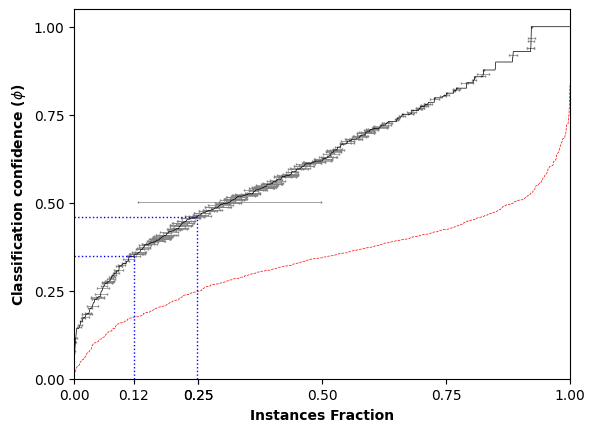

In [13]:
IMCP_curves=rTools.getIMCPCurves(y_test_pred_prob,y_test,classifierslabels=['XICPeakQlty'])
IMCP_curves.to_csv(os.path.join(modelEvalPath,"MCP_test_XICPeakQlty_model_RF.vd.tsv"),sep="\t",index=False)
IMCPU=rTools.getIMCPAveragedCurves(IMCP_curves,testStats)
IMCPU.to_csv(os.path.join(modelEvalPath,"MCPU_test_XICPeakQlty_model_RF.vd.tsv"),sep="\t",index=False)
IMCPavg=IMCP_curves[IMCP_curves.label=="XICPeakQlty"]
IMCPrnd=IMCP_curves[IMCP_curves.label=="XICPeakQlty_random"]

plt.errorbar(IMCPU.x_avg,IMCPU.phi_mean,xerr=IMCPU.x_U,fmt='o', ls='none',
             markersize=0.0,linewidth=2,capsize=1.025, color='black', ecolor='gray',
             elinewidth=0.5, markerfacecolor='green')
plt.plot(IMCPavg.x,IMCPavg.phi, color='black', linewidth=0.5)
plt.plot(IMCPrnd.x,IMCPrnd.phi, color='red', ls='--', linewidth=0.5)
plt.hlines(IMCPavg['1_minus_theta'][0], xmin=0.0, xmax=IMCPavg.x_lb[0], colors='blue', linestyles=':', linewidth=1.)
plt.hlines(IMCPavg['1_minus_eta'][0], xmin=0.0, xmax=IMCPavg.x_ub[0], colors='blue', linestyles=':', linewidth=1.)
plt.vlines(IMCPavg.x_lb[0], ymin=0.0, ymax=IMCPavg['1_minus_theta'][0], colors='blue', linestyles=':', linewidth=1.)
plt.vlines(IMCPavg.x_ub[0], ymin=0.0, ymax=IMCPavg['1_minus_eta'][0], colors='blue', linestyles=':', linewidth=1.)
plt.xlabel(r'Instances Fraction',fontweight='bold')
plt.ylabel(r'Classification confidence ($\phi$)',fontweight='bold')
plt.xticks(list(np.arange(0.0,1.1,0.25))+[round(IMCPavg.x_lb[0],2),round(IMCPavg.x_ub[0],2)])
plt.yticks(list(np.arange(0.0,1.05,0.25)))
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.show()

# **Final model fitting using all training data**

In [14]:
XICPeakQltyClassifier_final=RandomForestClassifier(max_features=__best_max_features,
                                                n_estimators=__best_n_estimators,
                                                criterion=__best_criterion,
                                                max_depth=__best_max_depth,
                                                ccp_alpha=__best_ccp_alpha,
                                                n_jobs=6,
                                                random_state=42)
XICPeakQltyClassifier_final.fit(training_data['features'],training_data['target'])
joblib.dump(XICPeakQltyClassifier_final, os.path.join(MLModelsPath,"XICPeakQlty_RF_model.vd.joblib"))

['./models/XIC-peakQlty/XICPeakQlty_RF_model.vd.joblib']